In [270]:
import jax
# jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from itertools import count
import jax.random as jr
import jax.scipy as jsci
from jax import jit,vmap, lax
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from functools import partial
from utils import *
from plotting_utils import *
from inference_and_sample import *
import task_subspace_LDS



keys = map(jr.PRNGKey, count())

In [271]:
print("jax:", jax.__version__)
print("devices:", jax.devices())
print("default backend:", jax.default_backend())

# !nvidia-smi

jax: 0.5.3
devices: [CudaDevice(id=0)]
default backend: gpu


In [272]:
# hyperparameters
D = 50
K1 = 1
K2 = 1
K = K1+K2
M = 2

S = 200
T = 100

In [273]:


# # norm of eig is p ** 2
# # imaginary part of eig is +/- p ** 2 / 2 * sqrt(4-gamma**2)

# fig, axes = plt.subplots(figsize=(5,5))
# eigW = jnp.linalg.eigvals(W)

# print(jnp.linalg.norm(eigW[0]))
# print(jnp.linalg.norm(eigW[1]))
# print(jnp.linalg.norm(eigW[2]))
# print(jnp.linalg.norm(eigW[3]))
# axes.scatter(jnp.real(eigW), jnp.imag(eigW), color='black', label='W low rank', marker='o')
# axes.set_xlabel('Re(eigenvalue)')
# axes.set_ylabel('Im(eigenvalue)')
# circle1 = plt.Circle((0, 0), 1, color='black', fill=False)
# axes.add_patch(circle1)
# axes.axvline(0, linestyle='dashed', color='black')
# axes.axhline(0, linestyle='dashed', color='black')
# axes.legend()




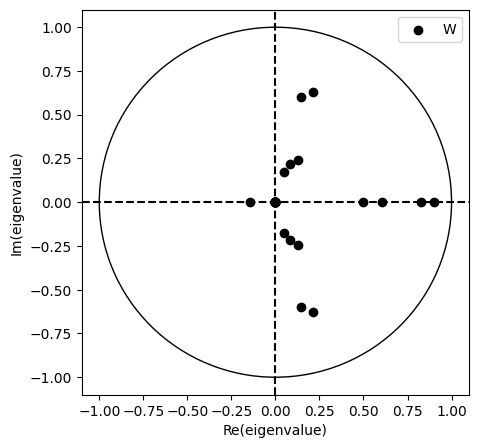

In [320]:


W = generate_low_rank_matrix(15, next(keys))
fig, axes = plt.subplots(figsize=(5,5))
eigW = jnp.linalg.eigvals(W)
axes.scatter(jnp.real(eigW), jnp.imag(eigW), color='black', label='W', marker='o')
axes.set_xlabel('Re(eigenvalue)')
axes.set_ylabel('Im(eigenvalue)')
circle1 = plt.Circle((0, 0), 1, color='black', fill=False)
axes.add_patch(circle1)
axes.axvline(0, linestyle='dashed', color='black')
axes.axhline(0, linestyle='dashed', color='black')
axes.legend()

(50, 50)
0.9441859093230697


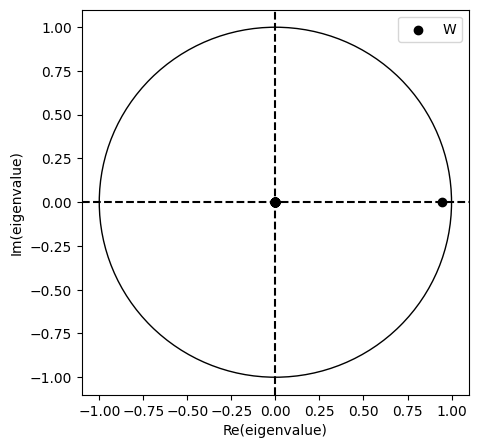

In [68]:
# first sample 3 * K1 orthogonal vectors in (D)-dim space
mean = jnp.zeros(D, dtype=jnp.float32)
cov  = jnp.eye(D, dtype=jnp.float32)
G = jr.multivariate_normal(next(keys), mean, cov, method='eigh', shape=(D,))
print(G.shape)
G, _ = jnp.linalg.qr(G)  # QR decomposition, Q is the orthogonal matrix
mo = G[:,0]
no = G[:,1]
w = G[:,2]

pm = jnp.sqrt(D) * jr.uniform(next(keys), shape=(K1,), minval=0.9, maxval=1)
pn = jnp.sqrt(D) * jr.uniform(next(keys), shape=(K1,), minval=0.9, maxval=1)
m = (mo + pm * w) / jnp.sqrt(D)
n = (no + pn * w) / jnp.sqrt(D)
W = jnp.outer(m,n)

print(pm[0]*pn[0] / D)

fig, axes = plt.subplots(figsize=(5,5))
eigW = jnp.linalg.eigvals(W)
axes.scatter(jnp.real(eigW), jnp.imag(eigW), color='black', label='W', marker='o')
axes.set_xlabel('Re(eigenvalue)')
axes.set_ylabel('Im(eigenvalue)')
circle1 = plt.Circle((0, 0), 1, color='black', fill=False)
axes.add_patch(circle1)
axes.axvline(0, linestyle='dashed', color='black')
axes.axhline(0, linestyle='dashed', color='black')
axes.legend()


[[0.85929643 0.        ]
 [0.10263254 0.        ]]


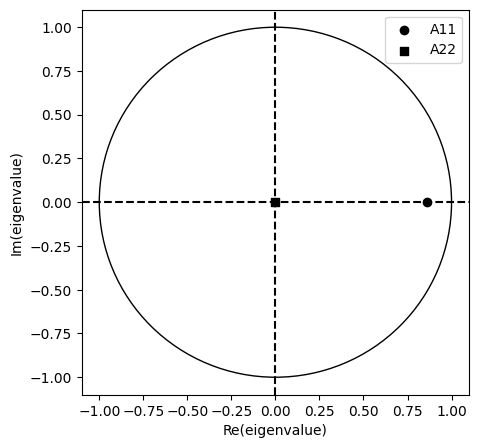

In [5]:
m_proj_n = n * jnp.dot(m,n)
m_ortho_n = m - m_proj_n
u_n = n / jnp.linalg.norm(n)

A11 = jnp.dot(u_n,m) * jnp.dot(n,u_n) 
A21 = jnp.dot(m_ortho_n,m) * jnp.dot(n,n)

A11 = A11.reshape((1,1))
A21 = A21.reshape((1,1))
A22 = jnp.zeros((1,1))
A12 = jnp.zeros((1,1))

trueA = jnp.block([[A11, A12],[A21, A22]])
print(trueA)


fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, jnp.linalg.eigvals(A11), jnp.linalg.eigvals(A22), color='black', label=['A11','A22'], alpha=1)
axes.legend()



In [6]:
# mean = jnp.zeros(D, dtype=jnp.float32)
# cov  = jnp.eye(D, dtype=jnp.float32)
# mo = jr.multivariate_normal(next(keys), mean, cov, shape = (K1,), method='eigh')
# no = jr.multivariate_normal(next(keys), mean, cov, shape = (K1,), method='eigh')
# w = jr.multivariate_normal(next(keys), mean, cov, shape = (K1,), method='eigh')
# pm = jr.uniform(next(keys), shape=(K1,), minval=0.2,maxval=1)
# pn = jr.uniform(next(keys), shape=(K1,), minval=0.8,maxval=1)
# M = mo + pm @ w 
# N = no + pn @ w 
# W = M.T @ N / D

# fig, axes = plt.subplots(figsize=(5,5))
# eigW = jnp.linalg.eigvals(W)
# axes.scatter(jnp.real(W), jnp.imag(W), color='black', label='W', marker='o')
# axes.set_xlabel('Re(eigenvalue)')
# axes.set_ylabel('Im(eigenvalue)')
# circle1 = plt.Circle((0, 0), 1, color='black', fill=False)
# axes.add_patch(circle1)
# axes.axvline(0, linestyle='dashed', color='black')
# axes.legend()


In [7]:
LDS = task_subspace_LDS.task_subspace_LDS(D, K1, K2, M)
trueu = LDS.generate_inputs(next(keys), S, T)
trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR = LDS.generate_other_parameters(next(keys), trueA)

In [8]:
# x_single, y_single = generate_latents_and_observations(next(keys), trueu[0], trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)

In [9]:
# whole sessions generation
keys_batch = jr.split(next(keys), S)
truex, truey = generate_latents_and_observations_batches(keys_batch, trueu, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)

In [10]:
mu, mu_prior, V, V_prior, ll = Kalman_filter_E_step_batches(truey, trueu, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)
m, cov, cov_successive = Kalman_smoother_E_step_batches(trueA, mu, mu_prior, V, V_prior)

In [11]:
# Per-session stats (each with leading S axis)
sufficient_stats = sufficient_statistics_E_step_batches(trueu, truey, m, cov, cov_successive)

print(m.shape)

# Sum across sessions for every leaf
stats = tree_map(lambda x: x.sum(axis=0), sufficient_stats)
M1, M1_T, M_next, Y1, Y2, Y_tilde, M_first, M_last, U1_T, U_tilde, U_delta = stats

print(M_first.shape)

(200, 100, 2)
(2, 2)


In [13]:
# G_inv = jnp.linalg.inv(G)
# print(G)
# mu, mu_prior, V, V_prior, ll = Kalman_filter_E_step_batches(truey, trueu, G @ trueA @ G_inv, G @ trueB, G @ trueQ @ G.T, G @ truemu0, G @ trueQ0 @ G.T, trueC @ G_inv, trued, trueR)
# m, cov, cov_successive = Kalman_smoother_E_step_batches(G @ trueA @ G_inv, mu, mu_prior, V, V_prior)

# # Per-session stats (each with leading S axis)
# sufficient_stats = sufficient_statistics_E_step_batches(trueu, truey, m, cov, cov_successive)

# # Sum across sessions for every leaf
# stats = tree_map(lambda x: x.sum(axis=0), sufficient_stats)
# M1, M1_T, M_next, Y1, Y2, Y_tilde, M_first, M_last, U1_T, U_tilde, U_delta = stats


In [14]:
# to check that compute ECLL gives same value with transformed sufficient stats or not

In [15]:
# fit staring from true parameters
_, _, _, _, _, _, _, _, _, _, _, ll_max, _ = LDS.fit_EM(trueu, truey, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR, max_iter=50)


In [16]:
print(ll_max[-1])

120036.64142637624


/tmp/ipykernel_17038/2880786494.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(loc='upper left')


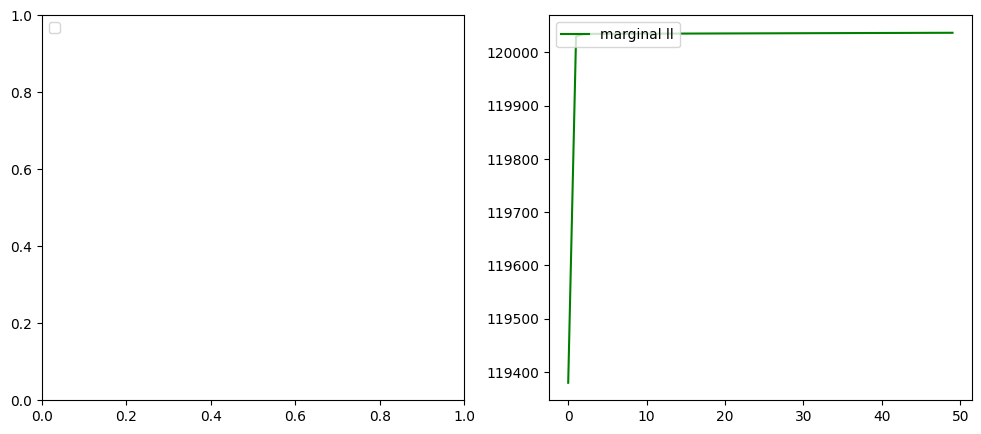

In [17]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
# print(ll.sum(axis=1))
axes[1].plot(ll_max, color='green', label='marginal ll')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')

(50, 50)
[7.48428061e+02 1.55948444e+00 3.95810648e-01 1.82439769e-01
 1.61599019e-01 1.43497797e-01 1.27198185e-01 1.25090895e-01
 1.01953901e-01 9.23032892e-02 8.62460862e-02 8.18532287e-02
 7.90210690e-02 7.03453224e-02 6.57579334e-02 5.91128613e-02
 5.39712734e-02 5.05499015e-02 4.62527913e-02 4.15308331e-02
 3.55091211e-02 3.31313718e-02 3.01966376e-02 2.86716428e-02
 2.72280740e-02 2.16629319e-02 1.91776581e-02 1.70490367e-02
 1.59230366e-02 1.43301519e-02 1.29116585e-02 1.18242190e-02
 9.19138375e-03 8.54082472e-03 7.46365530e-03 5.19999035e-03
 5.10399382e-03 4.42570488e-03 3.90722345e-03 3.41008479e-03
 2.64558253e-03 1.79984490e-03 1.67951724e-03 1.33465824e-03
 8.81590326e-04 7.02969100e-04 5.04747873e-04 2.41318728e-04
 1.30441938e-04 9.70871913e-05]


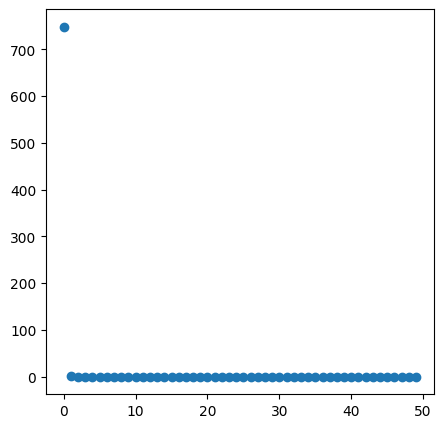

In [18]:
print((truey[0].T @ truey[0]).shape)

truey_pca = truey.mean(axis=0)
# print(truey_pca.mean(axis=0).shape)
truey_pca = truey_pca - truey_pca.mean(axis=0)

# SVD on Y^T Y is the same as PCA on Y
U, S, VT = jnp.linalg.svd(truey_pca.T @ truey_pca)  # U[:,:K] has K column vectors defining PCA space

# look at variance captured
fig, axes = plt.subplots(figsize=(5,5))
axes.scatter(range(S.shape[0]), S)
print(S)

In [19]:
# A, B, Q, mu0, Q0, C, d, R, timing_log = LDS.fit_EM_timed(K1, trueu, truey, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR,max_iter=5, verbosity=0, print_every=1)
# print(timinglog[-1])

# # fit staring from true parameters
# A, B, Q, mu0, Q0, C, d, R, ecll_new, ecll_old, elbo, ll = LDS.fit_EM(K1, trueu, truey, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR, max_iter=300)

# fit starting from random init
initeigs1 = generate_eigenvalues(next(keys), K1, R=0.999, r=0.8)
initeigs2 = generate_eigenvalues(next(keys), K2, R=0.3, r=0.1)
initA = LDS.generate_dynamics_matrix(next(keys), initeigs1, initeigs2)
# initA = initA.at[K1,K1].set(0)
initB, initQ, initmu0, initQ0, initC, initd, initR = LDS.generate_other_parameters(next(keys), initA)
# A, B, Q, mu0, Q0, C, d, R, ecll_new, ecll_old, elbo, ll = LDS.fit_EM(trueu, truey, initA, initB, trueQ, truemu0, trueQ0, trueC, initd, initR, max_iter=2000)
A, B, Q, mu0, Q0, C, d, R, ecll_new, ecll_old, elbo, ll, changes_param = LDS.fit_EM(trueu, truey, initA, initB, trueQ, truemu0, trueQ0, U[:,:K], initd, initR, max_iter=1000)

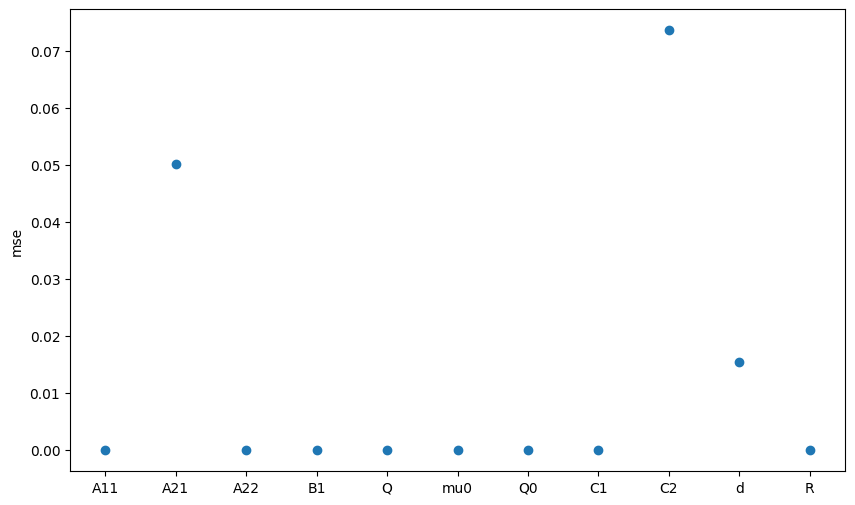

In [20]:
fig, axes = plt.subplots(figsize=(10,6))
plot_mse_parameters(axes, K1, A, B, Q, mu0, Q0, C, d, R, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)

In [21]:
# print(C[:,0])
# print(trueC[:,0])

In [23]:
# print(B)
# print(trueB)

[[ 0.86671055  0.        ]
 [-0.12115294  0.00741424]]
[[0.85929643 0.        ]
 [0.10263254 0.        ]]


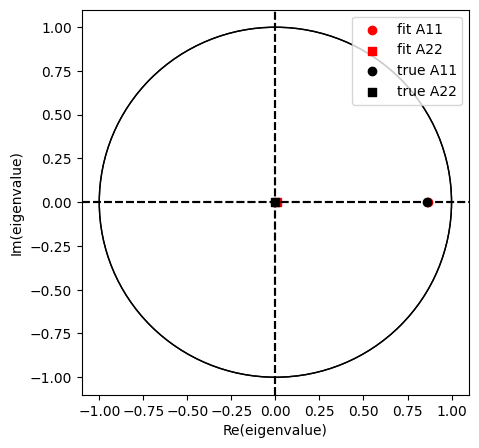

In [24]:
fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, jnp.linalg.eigvals(A[:K1,:K1]), jnp.linalg.eigvals(A[K1:,K1:]), color='red', label=['fit A11','fit A22'], alpha=1)
plot_eigenvalues(axes, jnp.linalg.eigvals(A11), jnp.linalg.eigvals(A22), color='black', label=['true A11','true A22'], alpha=1)
axes.legend()
print(A) 
print(trueA)

(17948.05898211182, 125636.41287478275)

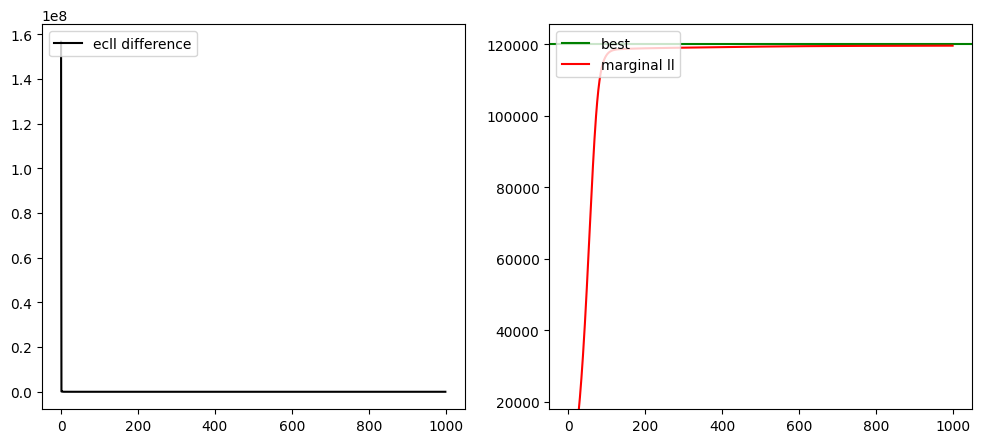

In [25]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
# print(ll.sum(axis=1))
axes[0].plot(ecll_new-ecll_old, color='black', label='ecll difference')
# axes[1].plot(elbo, color='purple', label='marginal ll')
axes[1].axhline(ll_max[-1], color='green', label='best')
axes[1].plot(ll, color='red', label='marginal ll')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[1].set_ylim(ll[-1]*0.15,ll[-1]*1.05)

Text(0, 0.5, 'norm of change in parameters')

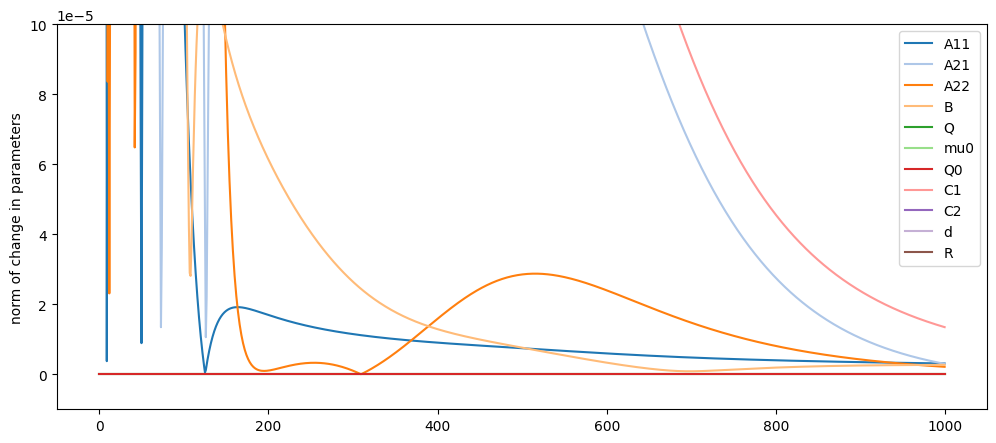

In [26]:
fig, axes = plt.subplots(1,figsize=(12,5))
import matplotlib as mpl
colors = mpl.colormaps['tab20'].colors 
# print(ll.sum(axis=1))
labels = ['A11', 'A21', 'A22', 'B', 'Q', 'mu0', 'Q0', 'C1','C2', 'd', 'R']
for z in range(11):
    axes.plot(changes_param[:,z], color=colors[z], label=labels[z])
axes.legend()
axes.set_ylim(-0.00001,0.0001)
axes.set_ylabel('norm of change in parameters')
# axes[1].plot(elbo, color='purple', label='marginal ll')
# axes[1].axhline(ll_max[-1], color='green', label='best')
# axes[1].plot(ll, color='red', label='marginal ll')
# axes[0].legend(loc='upper left')
# axes[1].legend(loc='upper left')
# axes[1].set_ylim(ll[-1]*0.15,ll[-1]*1.05)

In [27]:
print(ll[-2]-ll[-1])
print(ll[-2]/ll[-1])

-0.1939614677685313
0.9999983789767911


In [33]:
# # function to check convergence of LDS:

# def check_convergence_EM(ll_prev,ll_current):
#     if ll_prev - ll_current < 
    
    

In [34]:
# checking alignment of fitted C1 has same subspace with generative one
# print(jnp.linalg.norm(U[:,:K] @ U[:,:K].T @ trueC) / jnp.linalg.norm(trueC))
# print(jnp.linalg.norm(U[:,:K] @ U[:,:K].T @ trueC - trueC))

import scipy.linalg as sl
print("C1")
print(jnp.rad2deg(sl.subspace_angles(trueC[:,:K1], C[:,:K1])))
print(jnp.linalg.norm(trueC[:,:K1] @ trueC[:,:K1].T @ C[:,:K1]) / jnp.linalg.norm(C[:,:K1]))

print("C2")
print(jnp.rad2deg(sl.subspace_angles(trueC[:,K1:], C[:,K1:])))
print(jnp.linalg.norm(trueC[:,K1:] @ trueC[:,K1:].T @ C[:,K1:]) / jnp.linalg.norm(C[:,K1:]))

C1
[0.69443003]
0.9999265526018379
C2
[5.15911308]
0.9959488214789479


In [26]:
# checking that PCA on y gives C space, in the very low noise case
truex_noR, truey_noR = generate_latents_and_observations_batches(keys_batch, trueu, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, 1e-15 * jnp.eye((D)))




In [ ]:
# checking that doing PCA on data gives back true C or orthogonalization of C (mean-center data to avoid d appearing too!!!)
print((truey[0].T @ truey[0]).shape)

truey_pca = truey.mean(axis=0)
# print(truey_pca.mean(axis=0).shape)
truey_pca = truey_pca - truey_pca.mean(axis=0)

# SVD on Y^T Y is the same as PCA on Y
U, S, VT = jnp.linalg.svd(truey_pca.T @ truey_pca)  # U[:,:K] has K column vectors defining PCA space

# look at variance captured
fig, axes = plt.subplots(figsize=(5,5))
axes.scatter(range(S.shape[0]), S)
print(S)


In [29]:
# checking alignment of C and PCA space (note: C is PCA space without the first dimension which represents d)
print(jnp.linalg.norm(U[:,:K] @ U[:,:K].T @ trueC) / jnp.linalg.norm(trueC))
# print(jnp.linalg.norm(U[:,:K] @ U[:,:K].T @ trueC - trueC))

import scipy.linalg as sl
print(jnp.rad2deg(sl.subspace_angles(U[:,:K], trueC)))


0.9967440068030905
[6.54173586 0.27730654]


In [ ]:
Uc, Sc, VTc = jnp.linalg.svd(trueC, full_matrices=False) # do SVD to get orthogonal susbpace in which C lives
print(Uc.shape)
print(jnp.linalg.norm(U[:,:K] - Uc))


4.1805132565062045e-06
2.2161201315601405e-06


(200, 99, 5, 5)


-1977063.9066138251
-806.304519230697
